In [1]:
import os
from IPython.display import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pysd
from pysd.builders.stan.stan_model import StanVensimModel
from pysd.translators.vensim.vensim_file import VensimFile
from pysd.translators.xmile.xmile_file import XmileFile


import cmdstanpy # 2.30 is fastest (as of 08.12.2022) `cmdstanpy.install_cmdstan()` 
from cmdstanpy import CmdStanModel, cmdstan_path
import arviz as az #!pip install git+https://github.com/arviz-devs/arviz
az.style.use("arviz-darkgrid")

# set your working directiory
#os.chdir("/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts")

# Structuring Uncertainties in Dynamic Models: 
## Bayesian workflow of Predator-Prey Population Dynamics

Angie.H Moon, 07.2022

## Data: Predator and Prey Pelts in Canada

The species of interest in this case study are

- hares: prey, an hervivorous cousin of rabbits, and
- lynxes: predator, a feline predator whose diet consists largely of hares.

Spikes in the predator population lag those in the prey population. When populations are plotted against one another over time, the population dynamics orbit in an apparently stable pattern. Population oscillations can be modeled with a pair of differential equations similar to that used to describe springs. The first plot is the number of lynx and hare pelts (in thousands) collected for twenty years. The second plot is the phase plot of number of pelts collected for lynx versus hares similar to that of the dynamics of a spring in phase space (i.e., position vs. momentum).

[Text(0.5, 0, 'year'), Text(0, 0.5, 'pelt (thousands)')]

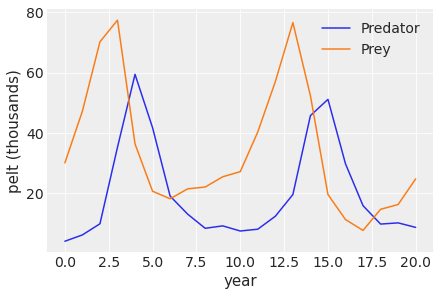

In [2]:
obs_stock_df = pd.read_csv('data/hudson-bay-lynx-hare.csv')
# data viz
pd.melt(obs_stock_df, id_vars = 'Year').iloc[[0,20,21,41]]
pd.melt(obs_stock_df, id_vars = 'Year').iloc[[0,1,20,21,40,41]].rename(columns = {'variable':'species', 'value':'pelts in thousands'})
ax = obs_stock_df.loc[:, ['Predator', 'Prey']].plot()
ax.set(xlabel='year', ylabel='pelt (thousands)') 

Phase plots are as below:

Text(0, 0.5, 'Prey pelts (thousands)')

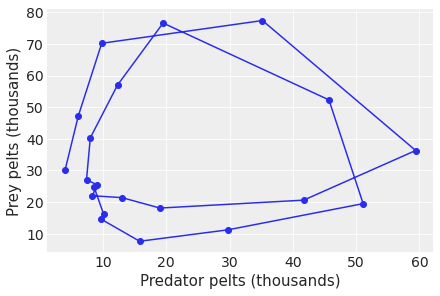

In [3]:
plt.scatter(obs_stock_df.loc[:, 'Predator'], obs_stock_df.loc[:, 'Prey'])
plt.plot(obs_stock_df.loc[:, 'Predator'], obs_stock_df.loc[:, 'Prey'])
plt.xlabel('Predator pelts (thousands)')
plt.ylabel('Prey pelts (thousands)')

## Mechanistic Model: The Lotka-Volterra Equations

In Lotka-Volterra equations (Lotka 1925; Volterra 1926, 1927), Volterra modeled the temporal dynamics of the two species (i.e., population sizes over times) in terms of four parameters, $\alpha, \beta, \gamma, \delta \geq 0$, as

$$
\begin{eqnarray}
\frac{\mathrm{d}}{\mathrm{d}t} u
& = &  (\alpha - \beta v) u
& = & \alpha u - \beta u v
\\[6pt]
\frac{\mathrm{d}}{\mathrm{d}t} v
& = &  (-\gamma + \delta \, u) \, v
& = & -\gamma v + \delta uv
\end{eqnarray}
$$

$u(t)$ and $v(t)$ are rendered as $u$ and $v$.  The factor $\alpha$, $\beta$ are the rate of birth and shrinkage relative to the product of the population sizes where as $\gamma$, $\delta$  are the shrinkage and growth rate as a factor of the product of the population sizes. Both u and v have positivitity constraints. as long as the initial populations are non-negative, i.e., $u(0) \geq 0$ and $v(0) \geq 0$, because the rate of change in each population is a factor of the population size itself.

The dynamic system has four limiting behavior:

1. If both population sizes are initially positive, the populations will oscillate in a fixed pattern indefinitely, remaining positive.
2. If both population sizes are initially zero, the population sizes will remain zero.
3. If the predator population size is zero and the prey population size positive, the predator population size remains zero and the prey population grows without bound.
4. If the predator population size is positive and the prey population size zero, the prey population size remains zero while the predator population shrinks toward zero size.

## Statistical Model: regreasion framing and uncertainty embedding

### Solving the inverse problem
Bayesian statistics is somewhat counterintuitive, as it involves formulating the generating model (from parameter to observed data) then using general principles to solve the inverse problem. Specifically, a Bayesian model requires a mathematical model of what we know about the parameters (i.e., a prior) and a model of what we know about the data generating process given the parameters (i.e., a sampling distribution.

Mathematically, a prior density $p(\theta)$ over the sequence of parameters $\theta$ encapsulates our knowledge of the parameters before seeing the data.  A sampling distribution (or likelihood), which may have a continuous, discrete or mixed probability function, $p(y | \theta)$ characterizes the distribution of observable data $y$ given parameters $\theta$. We limit the observation as stock variables as every SD model can be reformulated into the combination of stock and parameters.

Bayes's rule gives us a general solution to the inverse problem, expressing the posterior $p(\theta | y)$ in terms of the prior $p(\theta)$ and likelihood $p(y | \theta)$. Stan provides a form of Markov chain Monte Carlo (MCMC) sampling that draws a sample $\theta^{(1)}, \ldots, \theta^{(M)}$ from the posterior to use for computational inference. Posterior quantities of interest may be expressed as derived random variables using functions $f(\theta)$ of parameters. This feature is used for decision analysis; for instance, imagine a optimization problem of conservation cost of the park where prey and predator ecology places at. The cost can be computed based on the posterior distribution inferred from the observed time series.


### Uncertainty embedding for forward-backward symmetry required for calibration

The Lotka-Volterra model is deterministic in that given the value of the system parameter and initial outcome state, equation solutions (simulated outcome value) are fully determined. However, for empirical research which use posterior inference from the real data as it final forecast, forward model should be re-designed. This is because symmetry of forward and backward model (i.e. data generation and its inference) is the theoretical justification of calibration. To pass this internal consistency test (or with enough resource, SBC which is rank-statistics based), we need the two process to be the mirror image of other. This is why we purposefully embed uncertainty components, waiting to be captured in the inference step. The purpose is to test resilience and identifiability of our models evidenced by the perfect retrival of prior distribution for every uncertainty we embedded. 

### Linear regression analogy

Like in a simple linear regression, we will proceed by treating the underlying determinstic model as providing an expected population value around which there will be variation due to both measurement error and simplifications in the scientific model. Consider the typical formulation of a linear regression, where $y_n$ is an observable scalar outcome, $x_n$ is a row vector of unmodeled predictors (aka covariates, features), $\beta$ is a coefficient vector parameter, and $\sigma > 0$ is the error scale,

$$
\begin{eqnarray}
y_n & = & x_n \beta + \epsilon_n
\\[6pt]
\epsilon_n & \sim & \mathsf{Normal}(0, \sigma)
\end{eqnarray}
$$

### Adding measurement uncertainty (epistemic)
Before embedding parameteric uncertainty, linear predictor $x_n \beta$ with predictor $x_n$ (row $n$ of the data matrix $x$) and coefficient (column) vector $\beta$ are deterministic. The only source of uncertainty is from the measurement. This is expressed by assigning a normal distribution to error term $\epsilon_n$. Equal expression is with latent error variable $\epsilon_n$ as follows[<sup>17</sup>](#fn17), 

$$
y_n \sim \mathsf{Normal}(x_n \beta, \sigma).
$$

### Adding parameter uncertainty (epistemic)
Next, we add parameter uncertainty by coding estimated parameter as a distribution rather than a fixed value. This distribution is called prior distribution and from our example, Normal distirbution is chosen to endow the uncertainty to the four estimated parameters $\alpha, \beta, \gamma, \delta$. Considering their role difference, $\alpha, \gamma$ as multipliers of $u, -v$ and $\beta, \delta$ as multipliers of $uv$, prior parameter are chosen as N(1, 0.5) and N(0.05, 0.05) for each. For this selection, refer to the original case study [Carpenter18](https://mc-stan.org/users/documentation/case-studies/lotka-volterra-predator-prey.html).


### Adding aleatoric uncertainty
This applies only when we decide to add measurement uncertainty i.e. having initial value of stock variable as `est_param` instead of the default `ass_param`. For this, detailed explanation is added at the end of this file at Appendix A. 

## Prior predictive check

In [55]:
vf = VensimFile("vensim_models/prey-predator.mdl")
vf.parse()
am = vf.get_abstract_model()

# set time
n_t = obs_stock_df.shape[0] - 1 
premodel = StanVensimModel("prey-predator", am, 0.0, list(range(1, n_t + 1)))

# ode parameter 
premodel.set_prior("alpha", "normal", 0.55, 0.1)
premodel.set_prior("gamma", "normal", 0.8, 0.1)
premodel.set_prior("beta", "normal", 0.028, 0.01)
premodel.set_prior("delta", "normal", 0.024, 0.01)

# sampling distribution parameter
# model.set_prior("sigma", "lognormal", np.log(0.01), 0.1) 

premodel.build_stan_functions()
premodel.draws2data("")

prey-predator_functions.stan already exists in the current working directory. Overwrite? (Y/N): y


In [63]:
data_draws2data = {
    "n_obs_state" : 2
}

sf_path_draws2data = os.path.join(os.getcwd(), "stan_file", "prey-predator_draws2data.stan")
sm_draws2data = CmdStanModel(stan_file = sf_path_draws2data)

prior_pred = sm_draws2data.sample(data=data_draws2data, iter_sampling=3, chains=1, fixed_param=True, iter_warmup=0)
prior_pred.summary()

17:50:20 - cmdstanpy - INFO - compiling stan file /Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_draws2data.stan to exe file /Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_draws2data
17:50:28 - cmdstanpy - INFO - compiled model executable: /Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_draws2data
17:50:28 - cmdstanpy - WARNING - Stan compiler has produced 6 warnings:
17:50:28 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc --include-paths=/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file --o=/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_draws2data.hpp /Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_draws2data.stan
Warning in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_functions.stan', line 1, column 0, included from
'/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/s

chain 1 |          | 00:00 Status

17:50:29 - cmdstanpy - INFO - CmdStan done processing.


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
alpha_tilde,0.483423,NaN,0.168838,0.311738,0.489268,0.649262,NaN,NaN,NaN
gamma_tilde,0.772295,NaN,0.046225,0.719807,0.790143,0.806936,NaN,NaN,NaN
beta_tilde,0.025194,NaN,0.005654,0.020834,0.023166,0.031582,NaN,NaN,NaN
delta_tilde,0.013350,NaN,0.001347,0.012304,0.012875,0.014870,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
"y_tilde[19,1]",44.503100,NaN,47.742100,15.642200,18.256800,99.610200,NaN,NaN,NaN
"y_tilde[19,2]",20.489500,NaN,25.318600,3.256360,8.653860,49.558400,NaN,NaN,NaN
"y_tilde[20,1]",52.825400,NaN,60.818400,12.128700,23.608500,122.739000,NaN,NaN,NaN


For prior predictive checks, if the real observed data is indiscriminable from the simulated, we usually view it as a sign of pass. Real data is an external reference so as long as the predicted ranges are not too off, we give a pass to prior predictive check. Summary statistics such as N^th moments can be used for comparison. Few comments:

a. we use real data below as a representation of our knowledge, so prior predictive check is not double dipping (using data twice)

b. Bayesian prior corresponds to frequentist's regularization so having a tighter prior than posterior is not unnatrual; simply our determination to find a model concentrated around certain model configuration

c. if tight prior is well-placed, it prevents diveregence from frustrating geometry and boosts sampling efficiency

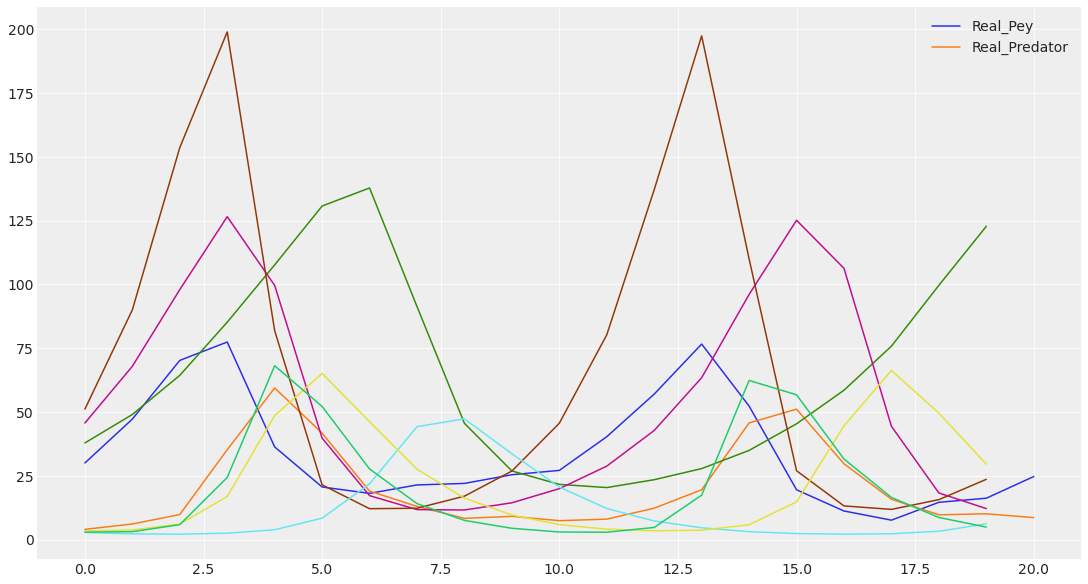

In [64]:
fig, ax = plt.subplots(figsize=(15, 8))
#compare with real 
ax.plot(obs_stock_df.loc[:, ['Prey']], label = "Real_Pey")
ax.plot(obs_stock_df.loc[:, ['Predator']], label = "Real_Predator")
ax.plot(pd.DataFrame(prior_pred.y_tilde[:,:,0]).T.loc[:, :5])
ax.plot(pd.DataFrame(prior_pred.y_tilde[:,:,1]).T.loc[:, :5])
ax.legend()

## Posterior predictive check

Now we estimate parameter values based on the real observed stock values. Here we use more diffuse prior.

In [36]:
vf = VensimFile("vensim_models/prey-predator.mdl")
vf.parse()
am = vf.get_abstract_model()

# set time
model = StanVensimModel("prey-predator", am, 0.0, list(range(1, n_t + 1)))

# ode parameter 
model.set_prior("alpha", "normal", 0.8, 0.1)
model.set_prior("gamma", "normal", 0.8, 0.1)
model.set_prior("beta", "normal", 0.05, 0.001)
model.set_prior("delta", "normal", 0.05, 0.001)

# sampling distribution parameter
# model.set_prior("sigma", "lognormal", np.log(0.01), 0.1) 

print(model.vensim_model_context.variable_names)

model.build_stan_functions()
model.draws2data("")
model.data2draws("")

{'predator_birth_rate', 'predator_death_rate', 'prey_death_rate', 'predator', 'gamma', 'final_time', 'delta', 'beta', 'time_step', 'prey_birth_rate', 'initial_time', 'saveper', 'prey', 'alpha'}


prey-predator_functions.stan already exists in the current working directory. Overwrite? (Y/N): y


In [43]:
sf_path_data2draws = os.path.join(os.getcwd(), "stan_file", "prey-predator_data2draws.stan")
sm_data2draws = CmdStanModel(stan_file = sf_path_data2draws)

n_t = obs_stock_df.shape[0] - 1
data_data2draws = {
    "n_obs_state" : 2,
    "initial_time" : 0, 
    "times": [i+1 for i in np.arange(n_t)],
    "n_t": n_t,
    "y": obs_stock_df.loc[1:, ('Predator', 'Prey')].values.tolist(),
}

fit = sm_data2draws.sample(data = data_data2draws, iter_sampling = 100, chains = 1, show_console = False, seed = 1234)

17:30:01 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

17:33:38 - cmdstanpy - INFO - CmdStan done processing.
17:33:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lognormal_lpdf: Random variable is -1.92663, but must be nonnegative! (in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_data2draws.stan', line 47, column 4 to column 45)
	Exception: ode_rk45:  Failed to integrate to next output time (11) in less than max_num_steps steps (in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_data2draws.stan', line 37, column 4 to column 126)
	Exception: ode_rk45:  Failed to integrate to next output time (10) in less than max_num_steps steps (in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_data2draws.stan', line 37, column 4 to column 126)
	Exception: lognormal_lpdf: Location parameter[1] is nan, but must be finite! (in '/Users/hyunjimoon/GoogleDrive_hmb/pysd/test_scripts/stan_file/prey-predator_data2draws.stan', line 51, column 8 to col

The following is the summary of posterior draws. It includes loglikelihood for each vector of parmaeter values $(\alpha, \beta, \gamma, \delta, \sigma)$. 

In [45]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-28706.500000,38.116500,65.862000,-28807.200000,-28708.900000,-28596.400000,2.98568,0.163527,2.54392
alpha,-0.954092,0.000034,0.000061,-0.954163,-0.954111,-0.953976,3.20337,0.175450,2.16126
gamma,-0.176430,0.000014,0.000029,-0.176466,-0.176439,-0.176368,4.28143,0.234496,1.51663
beta,0.181982,0.000205,0.000350,0.181401,0.181999,0.182485,2.90664,0.159198,2.69473
delta,-0.090545,0.000061,0.000112,-0.090727,-0.090552,-0.090335,3.39007,0.185676,2.07456
...,...,...,...,...,...,...,...,...,...
log_lik[16],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_lik[17],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_lik[18],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
idata = az.from_cmdstanpy(
    posterior=fit, 
    posterior_predictive=["y_hat"], 
    log_likelihood= ["log_lik"],
    observed_data = {"y": obs_stock_df.loc[:, ("Predator", "Prey")]}
#    dtypes={"y_rep": int} if Poisson family
)

In [51]:
az.loo(idata)
az.plot_ppc(idata, alpha=0.03, figsize=(12, 6))

/Users/hyunjimoon/GoogleDrive_hmb/pysd/venv/lib/python3.10/site-packages/arviz/stats/stats.py:802: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


KeyError: 'var names: "[\'y\'] are not present" in dataset'

## Appendix A. Measurement error, when stock initial is estimated parameter

Lastly, initial population is added to the list of estimated parameter. Instant reason for this modeling decision is measurement noise; as population cannot be directly measured pelts (our data) are used as its noisy proxy). However, more fundamental reason is aletoric uncertainty, namely unmodeled uncertainty. There are factors that impact predator and prey population size other than the current population size. There are variable environmental effects, such as weather, which will vary from season to season and year to year and affect population sizes. Infectious diseases occasionally spread through a population, reducing its size (Hewitt 1921). There are also more long-term environmental factors such as carrying capacity (Carrying capacity is roughly the maximum population that an environment can sustain. It is often modeled in the system dynamics as an asymptote on population size.). However, our forward model is restricted to two differential equations involving two stock variables (`simulated outcome`) and four `estimated coefficient parameter`s (four flow variables can be expressed with the other two). Hence, after restricting the architecture, we are reaching out to the best version of ourselve by declaring the initial population as estimated parameter. In Stat/Machine learning terms, Stan optimization algorithm returns `estimated parameter` value that maximize log posterior among the feasible (restricted basis function) space defined by the modeler in the form of stock-parameter relationship.

Continuing on `simulated outcome` and `observed outcome` coflow, `observed outcome` can replace `simulated outcome` also known as state-resetting but we maintain the error term to compensate for measurement error and unexplained variation in the data (Challenge: check whether this is equivalent to the original text "Solutions to the Lotka-Volterra equations replace the linear predictor xnβ, but we maintain the error term to compensate for measurement error and unexplained variation in the data."). In the case of population dynamics, the data $y_n$ consists of measurements of the prey $y_{n, 1}$ and predator $y_{n, 2}$ populations at times $t_n$[<sup>18</sup>](#fn18).

The true population sizes at time $t = 0$ are unknown---we only have measurements $y^{\rm init}_1$ and $y^{\rm init}_2$ of them. The true initial population sizes at time $t = 0$ will be represented by a parameter $z^{\mathrm init}$, so that

$$
\begin{array}{rcl}
z^{\mathrm init}_1 & = & u(t = 0)
\\[4pt]
z^{\mathrm init}_2 & = & v(t = 0).
\end{array}
$$

Next, let $z_1, \ldots, z_N$ be the solutions to the Lotka-Volterra differential equations at times $t_1, \ldots, t_N$ given initial conditions $z(t = 0) = z^{\mathrm init}$ and parameters $\theta = (\alpha, \beta, \gamma, \delta)$. Each $z_n$ is a pair of prey and predator population sizes at the specified times,

$$
\begin{array}{rcl}
z_{n, 1} & = & u(t_n)
\\[4pt]
z_{n, 2} & = &  v(t_n).
\end{array}
$$

The $z_n$ are random variables, but they are deterministic functions of the random variables for the initial state $z^{\mathrm init}$ and system parameters $\alpha, \beta, \gamma, \delta$.

The observed data is in the form of measurements $y^{\rm init}$ of the initial population of prey and predators, and subsequent measurements $y_n$ of the populations at times $t_n$, where $y^{\mathrm init}$ and the $y_n$ consist of a pair of measured population sizes, for the prey and predator species.

In summary, the measurements, $y^{\rm init}$ and $y_n$, are drawn indepently from a normal distribution centered at the underlying population sizes, $z^{\rm init}$ and $z_n$, with noise scales $\sigma$.




## Appendix B. Stan code

The following is the auto-generated stanfile with modularized funtion block in the cell below.
```
functions{
#include prey-predator_functions.stan
}
data{
    int <lower = 1> n_obs_state;
    real initial_time;
    int <lower = 1> n_t; 
    array[n_t] real times;
    array[n_t] vector[n_obs_state] y; 
}


parameters{
    real alpha;
    real gamma;
    real beta;
    real delta;
    real sigma;
}

transformed parameters {
    # Initial ODE values
    real prey_initial = 30;
    real predator_initial = 4;

    vector[2] initial_outcome;  # Initial ODE state vector
    initial_outcome[1] = prey_initial;
    initial_outcome[2] = predator_initial;

    vector[2] integrated_result[n_t] = ode_rk45(vensim_func, initial_outcome, initial_time, times, alpha, beta, gamma, delta, sigma);
}

model{
    alpha ~ normal(0.8, 0.1);
    gamma ~ normal(0.8, 0.1);
    beta ~ normal(0.05, 0.001);
    delta ~ normal(0.05, 0.001);
    sigma ~ lognormal(-4.605170185988091, 1);
    for (s in 1: n_obs_state){
        y[:, s] ~ lognormal(log(integrated_result[:, s]), sigma);
    }
}

generated quantities{
    array[n_t] vector[n_obs_state] y_ppc;
    vector[n_t] log_lik;
    for (s in 1: n_obs_state){
        y_ppc[:, s] = lognormal_rng(log(integrated_result[:, s]), sigma);
    } 
    for (s in 1: n_obs_state){
        //elementwise log likliehood
        log_lik[s] = lognormal_lpdf(y[s]|log(integrated_result[:, s]), sigma);
    }
}
```

Function block:
```
# Begin ODE declaration
vector vensim_func(real time, vector outcome, real alpha, real beta, real gamma, real delta){
    vector[2] dydt;  # Return vector of the ODE function

    # State variables
    real prey = outcome[1];
    real predator = outcome[2];

    real prey_birth_rate = alpha * prey;
    real predator_birth_rate = delta * prey * predator;
    real prey_death_rate = beta * predator * prey;
    real prey_dydt = prey_birth_rate - prey_death_rate;
    real predator_death_rate = gamma * predator;
    real predator_dydt = predator_birth_rate - predator_death_rate;

    dydt[1] = prey_dydt;
    dydt[2] = predator_dydt;

    return dydt;
}


```